In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [3]:
train_data= pd.read_csv('train_data_iitm.csv')   
train_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge
0,2.0,2020-06-10 13:36:49,2020-06-10 13:51:08,1.0,2.73,1.0,N,224,148,2.0,12.00,2.5
1,NaN,2020-06-13 06:19:00,2020-06-13 06:37:00,NaN,11.58,NaN,NaN,56,42,NaN,28.81,0.0
2,2.0,2020-06-20 07:59:23,2020-06-20 08:05:39,1.0,2.05,1.0,N,79,68,2.0,8.00,2.5
3,1.0,2020-06-27 15:11:32,2020-06-27 15:15:02,1.0,1.40,1.0,N,236,75,1.0,6.00,2.5
4,1.0,2020-06-26 16:00:36,2020-06-26 16:02:28,1.0,0.60,1.0,N,186,90,2.0,4.00,2.5


In [4]:
train_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge
count,54365.000000,54365.000000,60000.000000,54365.000000,60000.000000,60000.000000,54365.000000,60000.000000,60000.000000
mean,1.597554,1.353702,3.368568,1.047383,157.733683,153.572183,1.373604,13.626738,1.965417
std,0.490395,1.012809,4.323149,1.078021,69.510520,73.940982,0.532802,13.454365,1.048347
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-149.000000,-2.500000
25%,1.000000,1.000000,1.010000,1.000000,107.000000,87.000000,1.000000,6.000000,2.500000
50%,2.000000,1.000000,1.850000,1.000000,151.000000,151.000000,1.000000,9.000000,2.500000
75%,2.000000,1.000000,3.670000,1.000000,234.000000,233.000000,2.000000,15.500000,2.500000
max,2.000000,6.000000,114.300000,99.000000,265.000000,265.000000,5.000000,400.000000,2.500000


In [5]:
train_data.isnull().sum()

VendorID                 5635
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          5635
trip_distance               0
RatecodeID               5635
store_and_fwd_flag       5635
PULocationID                0
DOLocationID                0
payment_type             5635
fare_amount                 0
congestion_surcharge        0
dtype: int64

Around 10% of the data is null

<AxesSubplot: xlabel='fare_amount', ylabel='Count'>

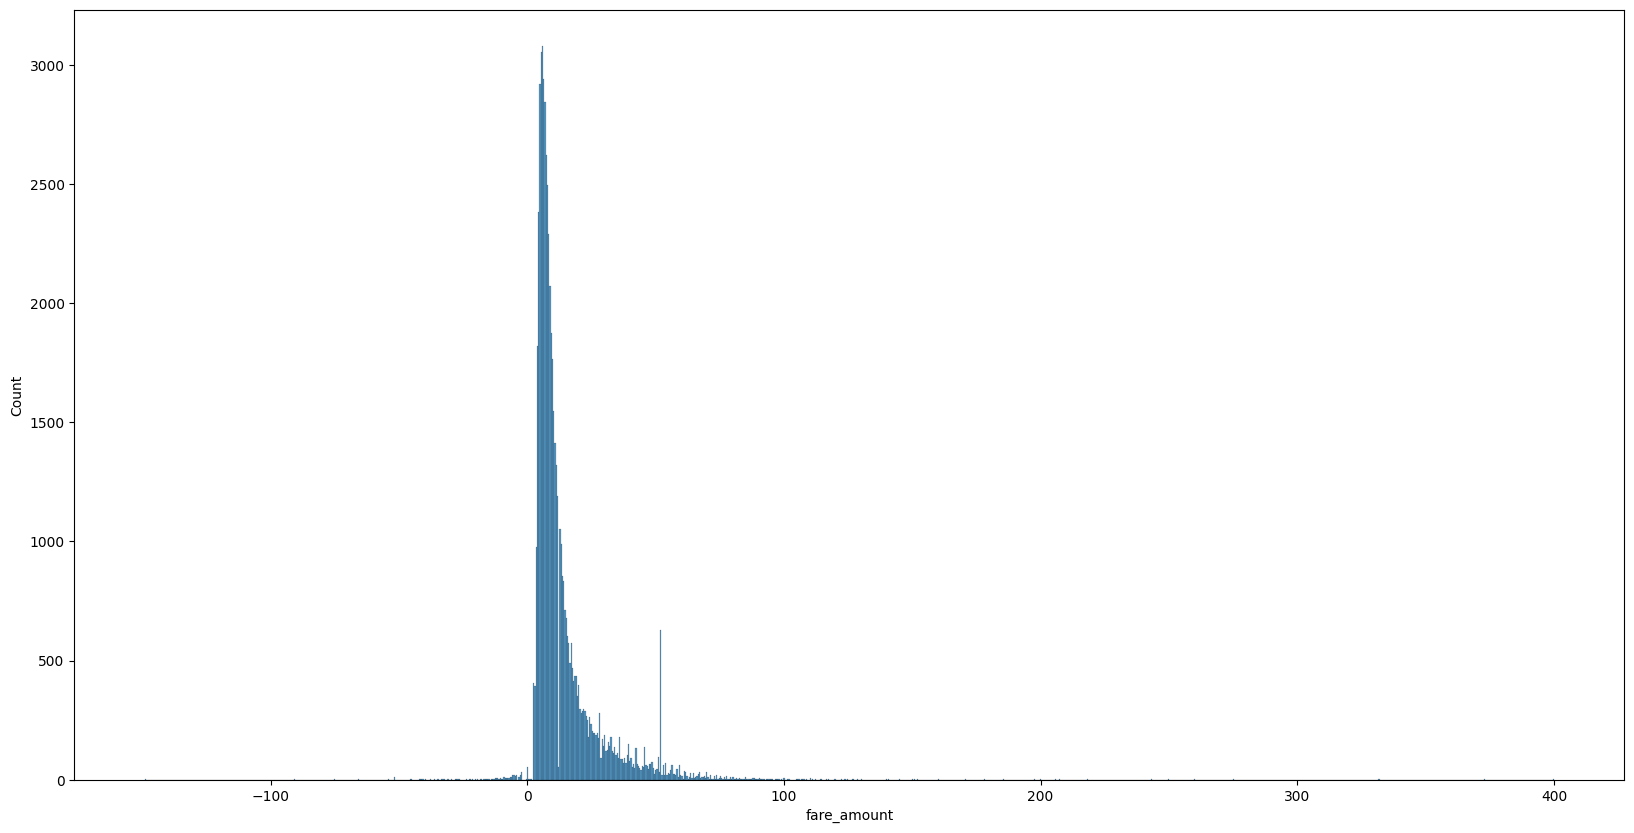

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sb.histplot(train_data.fare_amount)

We see that the distribution of fare_amount data is skewed, hence we use median to fill null values

In [7]:
train_data.fillna(train_data.median(),inplace=True)

In [8]:
train_data = train_data.drop('store_and_fwd_flag',axis=1)

In [9]:
drop_i = train_data[train_data.fare_amount <0].index                        #removing all fare amounts less than 0
train_data = train_data.drop(drop_i)

drop_i = train_data[train_data.trip_distance <0].index                      #removing all trip distance less than 0
train_data = train_data.drop(drop_i)

drop_i = train_data[train_data.congestion_surcharge <0].index               #removing all congestion_surcharge less than 0
train_data = train_data.drop(drop_i)

drop_i = train_data[train_data.payment_type > 6].index                      #Since payment type can take only values between 1 and 6 we remove values greater than 6
train_data = train_data.drop(drop_i) 

drop_i = train_data[train_data.RatecodeID > 6].index                        #Since RatecodeID can take only values between 1 and 6 we remove values greater than 6
train_data = train_data.drop(drop_i) 

In [10]:
def time_features_pickup(df,time_col):                                  
    df[time_col] = pd.to_datetime(df[time_col])
    df['dayofweek'] = pd.to_datetime(df[time_col]).dt.dayofweek
    df['month'] = pd.to_datetime(df[time_col]).dt.month
    df['hour'] = pd.to_datetime(df[time_col]).dt.hour
    df['pickup_minute'] = pd.to_datetime(df[time_col]).dt.minute
    return df

def time_features_drop(df,time_col):
    df[time_col] = pd.to_datetime(df[time_col])
    df['drop_minute'] = pd.to_datetime(df[time_col]).dt.minute
    return df

In [11]:
train_data = time_features_pickup(train_data,'tpep_pickup_datetime')
train_data = time_features_drop(train_data,'tpep_dropoff_datetime')

In [12]:
train_data.shape

(59700, 16)

# Checking for Outliers

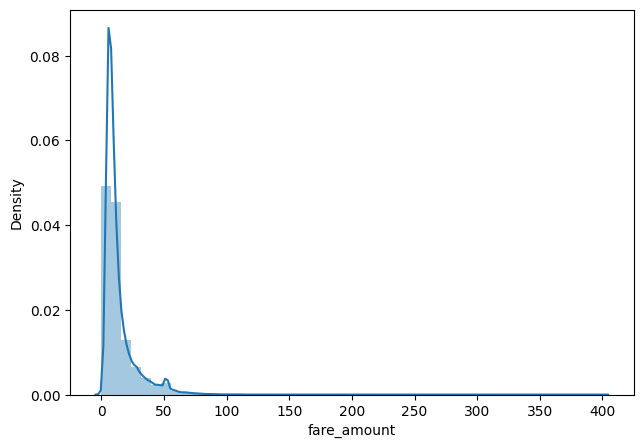

In [13]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,2)
sb.distplot(train_data['fare_amount'])
plt.show()

<AxesSubplot: >

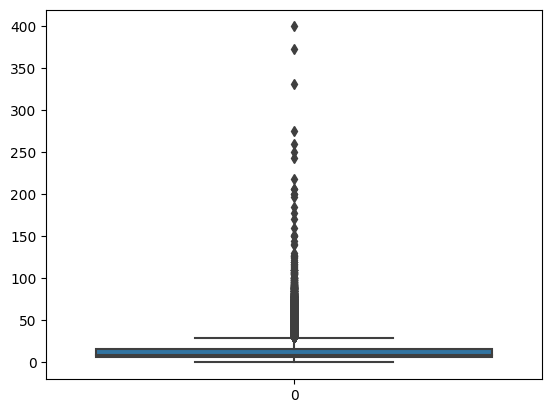

In [14]:
sb.boxplot(train_data['fare_amount'])

In [15]:
percentile25 = train_data['fare_amount'].quantile(0.25)
percentile75 = train_data['fare_amount'].quantile(0.75)
iqr = percentile75-percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [16]:
train_data[train_data['fare_amount'] > upper_limit]
train_data[train_data['fare_amount'] < lower_limit]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge,dayofweek,month,hour,pickup_minute,drop_minute


In [17]:
df_train = train_data[train_data['fare_amount'] < upper_limit]
df_train = train_data[train_data['fare_amount'] > lower_limit]
train_data.shape[0]-df_train.shape[0]

5850

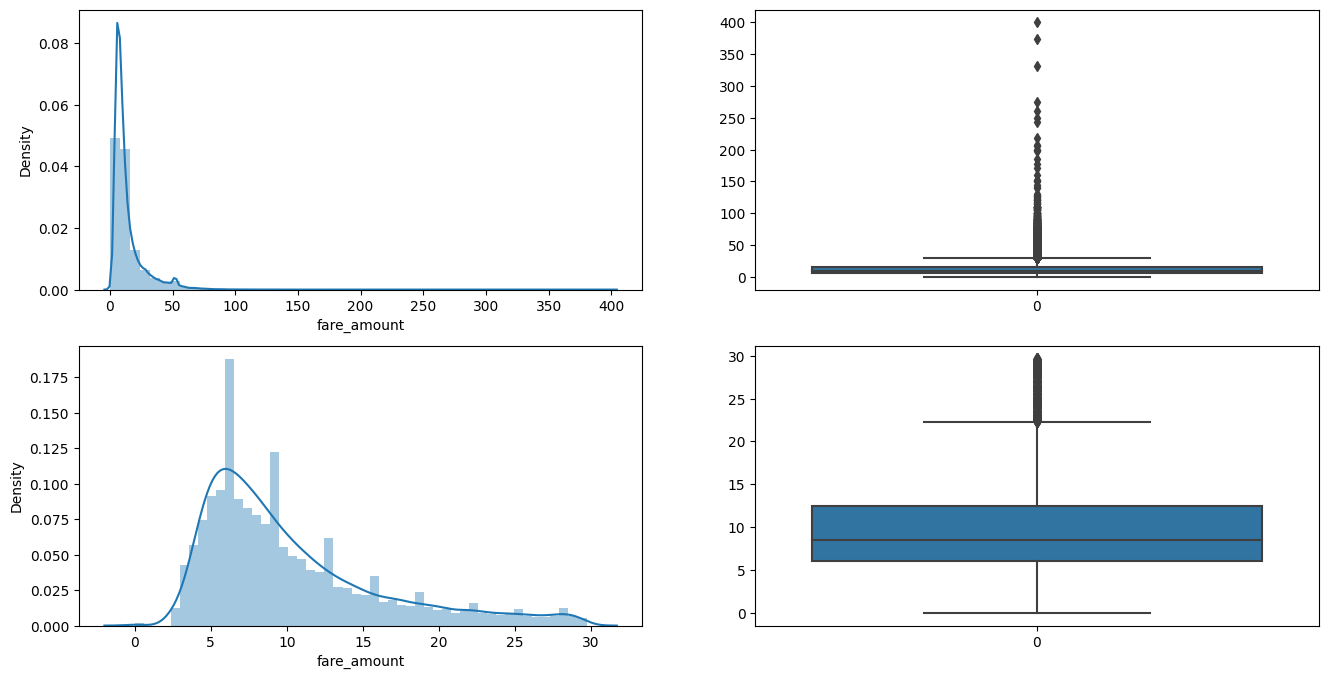

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sb.distplot(train_data['fare_amount'])
plt.subplot(2,2,2)
sb.boxplot(train_data['fare_amount'])
plt.subplot(2,2,3)
sb.distplot(df_train['fare_amount'])
plt.subplot(2,2,4)
sb.boxplot(df_train['fare_amount'])
plt.show()

<AxesSubplot: >

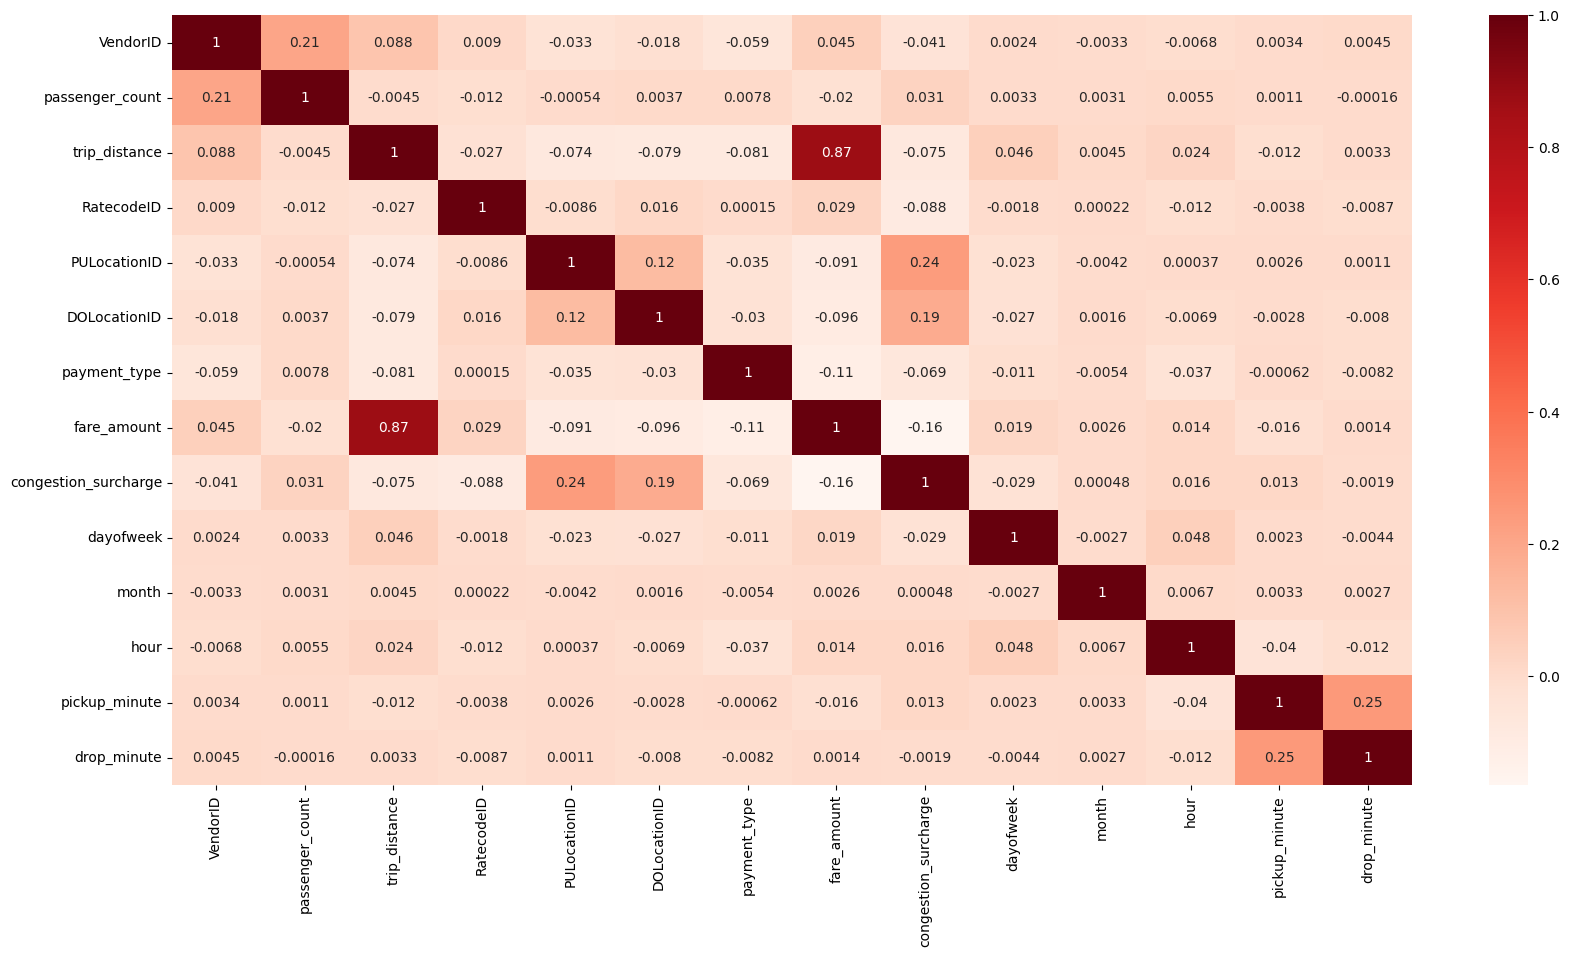

In [19]:
pearson_corr = df_train.corr()
plt.figure(figsize = (20,10))
sb.heatmap(data = pearson_corr, cmap = "Reds", annot = True)

# Comparing Different Regression Models

In [20]:
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse

In [21]:
test_data = pd.read_csv('test_data_iitm.csv')
test_data = time_features_pickup(test_data,'tpep_pickup_datetime')
test_data = time_features_drop(test_data,'tpep_dropoff_datetime')
test_dat = test_data.drop(["tpep_pickup_datetime","tpep_dropoff_datetime","store_and_fwd_flag"],axis = 1).dropna()

In [22]:
train_dat = df_train.drop(["tpep_pickup_datetime","tpep_dropoff_datetime"],axis = 1)

In [23]:
y = train_dat["fare_amount"]
x = train_dat.drop(["fare_amount"],axis = 1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

# Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression(normalize=True)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
print("LinearRegression:")
print("Train Accuracy:",lr.score(x_train,y_train))
print("Test Accuracy:",lr.score(x_test,y_test))
print("Root Mean squared error:",mse(y_test, y_pred,squared=False),"\n")

LinearRegression:
Train Accuracy: 0.7662733238048789
Test Accuracy: 0.7956882733849873
Root Mean squared error: 2.60882393614771 



# Lasso

In [25]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(x_train,y_train)
y_pred = reg.predict(x_test)
print("Lasso:")
print("Train Accuracy:",reg.score(x_train,y_train))
print("Test Accuracy:",reg.score(x_test,y_test))
print("Root Mean squared error:",mse(y_test, y_pred,squared=False),"\n")

Lasso:
Train Accuracy: 0.7616827714855512
Test Accuracy: 0.7898573656732892
Root Mean squared error: 2.6457890188768465 



# Decision Tree

In [26]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print("DecisionTreeRegressor:")
print("Train Accuracy:",clf.score(x_train,y_train))
print("Test Accuracy:",clf.score(x_test,y_test))
print("Root Mean squared error:",mse(y_test, y_pred,squared=False),"\n")

DecisionTreeRegressor:
Train Accuracy: 1.0
Test Accuracy: 0.7971883931278017
Root Mean squared error: 2.599228896081432 



# Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
reg2 = RandomForestRegressor(random_state=1)
reg2.fit(x_train,y_train)
y_pred_train=reg2.predict(x_train)
y_pred = reg2.predict(x_test)
print("RandomForestRegressor:")
print("Train Accuracy:",reg2.score(x_train,y_train))
print("Test Accuracy:",reg2.score(x_test,y_test))
print("Train Root Mean squared error:",mse(y_train, y_pred_train,squared=False))
print("Test Root Mean squared error:",mse(y_test, y_pred,squared=False),"\n")

RandomForestRegressor:
Train Accuracy: 0.9857649239257243
Test Accuracy: 0.9022327795776582
Train Root Mean squared error: 0.7007997830365903
Test Root Mean squared error: 1.804657362142055 



# Gradient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
reg1 = GradientBoostingRegressor()
reg1.fit(x_train,y_train)
y_pred_train=reg1.predict(x_train)
y_pred = reg1.predict(x_test)
print("GradientBoostingRegressor:")
print("Train Accuracy:",reg1.score(x_train,y_train))
print("Test Accuracy:",reg1.score(x_test,y_test))
print("Train Root Mean squared error:",mse(y_train, y_pred_train,squared=False))
print("Test Root Mean squared error:",mse(y_test, y_pred,squared=False))

GradientBoostingRegressor:
Train Accuracy: 0.8856519070649586
Test Accuracy: 0.8810139438041386
Train Root Mean squared error: 1.9862253729966175
Test Root Mean squared error: 1.990884926809293


# XGBoost

In [29]:
import xgboost as xgb
regx=xgb.XGBRegressor()
regx.fit(x_train,y_train)
y_pred_train=regx.predict(x_train)
y_pred = regx.predict(x_test)
print("xgboost:")
print("Train Accuracy:",regx.score(x_train,y_train))
print("Test Accuracy:",regx.score(x_test,y_test))
print("Train Root Mean squared error:",mse(y_train, y_pred_train,squared=False))
print("Test Root Mean squared error:",mse(y_test, y_pred,squared=False))

xgboost:
Train Accuracy: 0.9681838418823132
Test Accuracy: 0.9288765169409469
Train Root Mean squared error: 1.047702380428772
Test Root Mean squared error: 1.539233943263141


# LightGBM

In [30]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor()
gbm.fit(x_train,y_train)
y_pred_train=gbm.predict(x_train)
y_pred = gbm.predict(x_test)
print("lightgbm:")
print("Train Accuracy:",gbm.score(x_train,y_train))
print("Test Accuracy:",gbm.score(x_test,y_test))
print("Train Root Mean squared error:",mse(y_train, y_pred_train,squared=False))
print("Test Root Mean squared error:",mse(y_test, y_pred,squared=False))

lightgbm:
Train Accuracy: 0.9235543417041074
Test Accuracy: 0.9051658970023752
Train Root Mean squared error: 1.6240166404565735
Test Root Mean squared error: 1.7773804293608921
